In [1]:
import sys
import os
import re
import time
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import pandas as pd


sys.path.append('code/')
from data_structures import MultiIndexDFObject
from utils import *

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

try:
    import umap
    import umap.plot
except:
    !pip install umap-learn[plot]

plt.style.use('seaborn-deep')

In [2]:
# could load a previously saved file in order to plot
parquet_loadname = 'data/df_lc_.parquet.gzip'
parallel_df_lc = MultiIndexDFObject()
parallel_df_lc.data = pd.read_parquet(parquet_loadname)


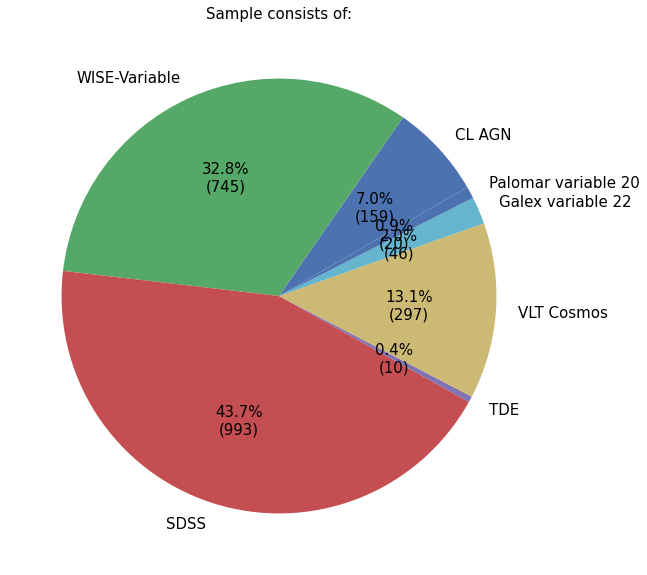

In [3]:
from collections import Counter
numobj = len(parallel_df_lc.data.index.get_level_values('objectid')[:].unique())
seen = Counter()
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']

for b in range(numobj):
    singleobj = parallel_df_lc.data.loc[b,:,:,:]  
    label = singleobj.index.unique('label')
    if label in cl_labels:
        label = ['CL AGN']
    if label=='ZTF-Objname':
        label= ['TDE']
    if label=='Cicco19':
        label= ['VLT Cosmos']
                
    seen.update(label)

plt.figure(figsize=(10,10))
plt.title(r'Sample consists of:',size=15)
h = plt.pie(seen.values(),labels=seen.keys(),autopct=autopct_format(seen.values()), textprops={'fontsize': 15},startangle=30,  labeldistance=1.1)

Text(0, 0.5, '#')

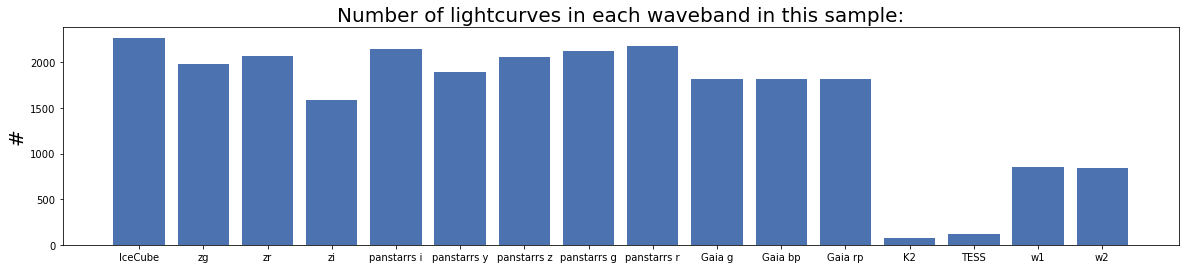

In [4]:
seen = Counter()
for b in range(numobj):
    singleobj = parallel_df_lc.data.loc[b,:,:,:]  
    label = singleobj.index.unique('label')
    bands = singleobj.loc[b,label[0],:,:].index.get_level_values('band')[:].unique()
    seen.update(bands)

plt.figure(figsize=(20,4))
plt.title(r'Number of lightcurves in each waveband in this sample:',size=20)
h = plt.bar(seen.keys(), seen.values())
plt.ylabel(r'#',size=20)

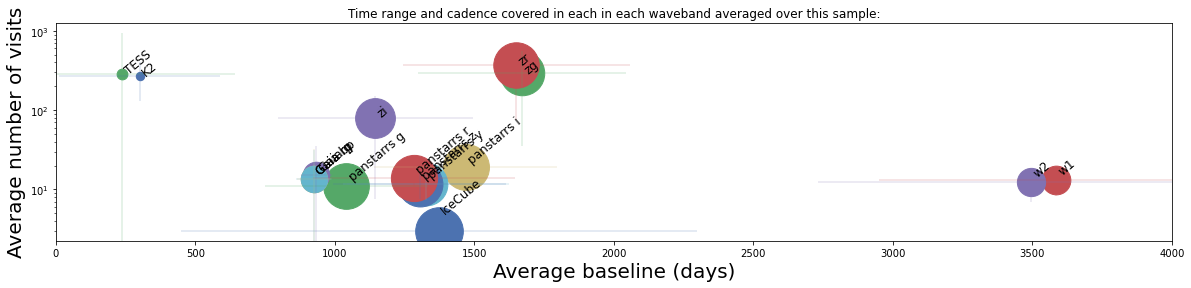

In [5]:
cadence = dict((el,[]) for el in seen.keys())
timerange = dict((el,[]) for el in seen.keys())

for b in range(numobj):
    singleobj = parallel_df_lc.data.loc[b,:,:,:]  
    label = singleobj.index.unique('label')
    bband = singleobj.index.unique('band')
    for bb in bband:
        bands = singleobj.loc[b,label[0],bb,:].index.get_level_values('time')[:]
        #bands.values
        #print(bb,len(bands[:]),np.round(bands[:].max()-bands[:].min(),1))    
        cadence[bb].append(len(bands[:]))
        if bands[:].max()-bands[:].min()>0:
            timerange[bb].append(np.round(bands[:].max()-bands[:].min(),1))    

plt.figure(figsize=(20,4))
plt.title(r'Time range and cadence covered in each in each waveband averaged over this sample:')
for el in cadence.keys():
    #print(el,len(cadence[el]),np.mean(cadence[el]),np.std(cadence[el]))
    #print(el,len(timerange[el]),np.mean(timerange[el]),np.std(timerange[el]))
    plt.scatter(np.mean(timerange[el]),np.mean(cadence[el]),label=el,s=len(timerange[el]))
    plt.errorbar(np.mean(timerange[el]),np.mean(cadence[el]),xerr=np.std(timerange[el]),yerr=np.std(cadence[el]),alpha=0.2)
    plt.annotate(el,(np.mean(timerange[el]),np.mean(cadence[el])+2),size=12, rotation=40)
plt.ylabel(r'Average number of visits',size=20) 
plt.xlabel(r'Average baseline (days)',size=20) 
plt.xlim([0,4000])
plt.yscale('log')

  0%|          | 0/2270 [00:00<?, ?it/s]

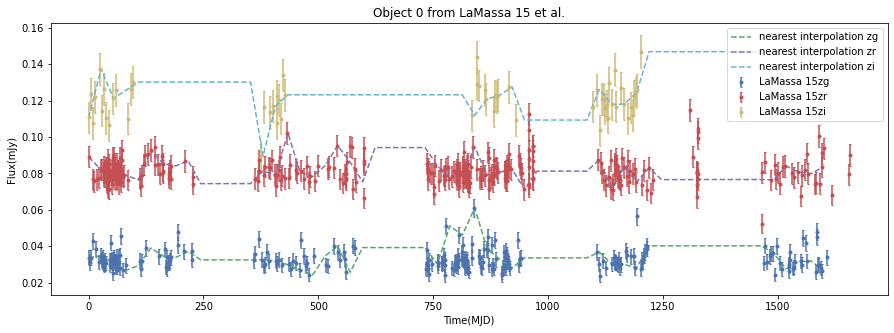

  0%|          | 1/2270 [00:00<17:40,  2.14it/s]

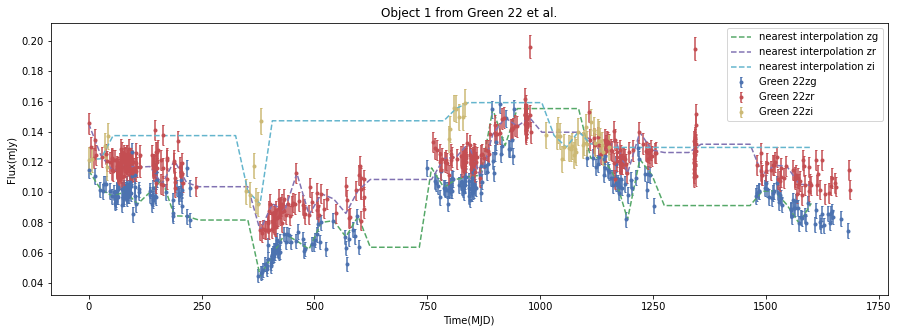

  0%|          | 2/2270 [00:00<17:07,  2.21it/s]

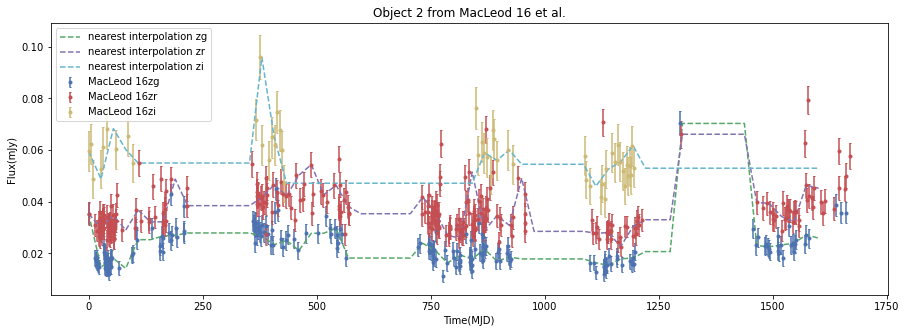

  0%|          | 3/2270 [00:01<17:14,  2.19it/s]

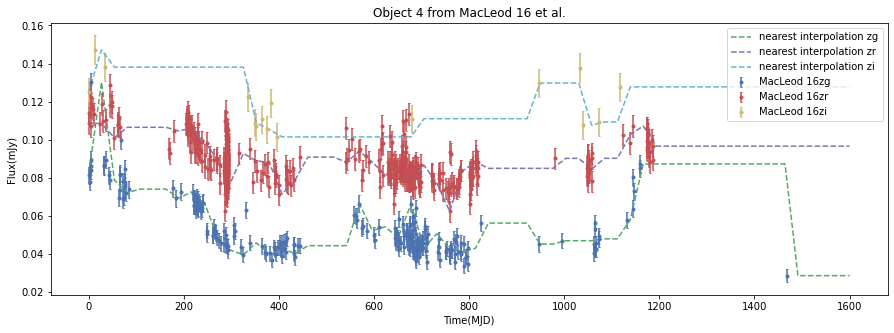

  0%|          | 5/2270 [00:01<14:53,  2.53it/s]

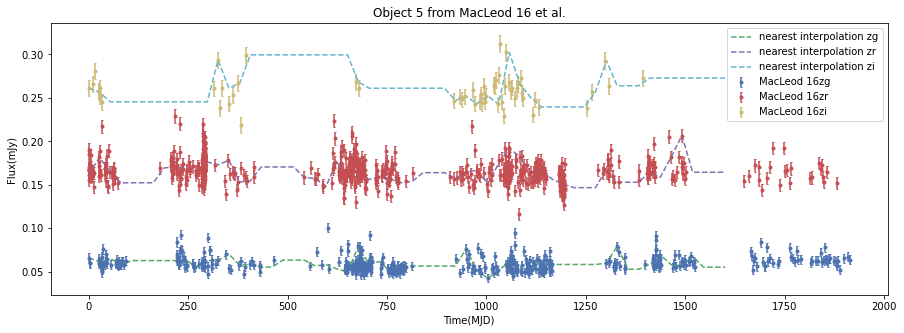

100%|██████████| 2270/2270 [01:11<00:00, 31.95it/s]


In [6]:
bands_inlc = ['zg','zr','zi']#,'panstarrs g','panstarrs r','panstarrs i','panstarrs z', 'panstarrs y']
objects,dobjects,flabels = unify_lc(parallel_df_lc,bands_inlc,xres=60,numplots=5)


In [7]:
fvar, maxarray, meanarray = stat_bands(objects,dobjects,bands_inlc)

dat = combine_bands(objects,bands_inlc)
dat = normalize_clipmax_objects(dat,maxarray)
data,fzr,p = shuffle_datalabel(dat,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for i,l in enumerate(fzr):
    if l in cl_labels:
        fzr[i] = 'CL AGN'
    if l=='ZTF-Objname':
        fzr[i] = 'TDE'

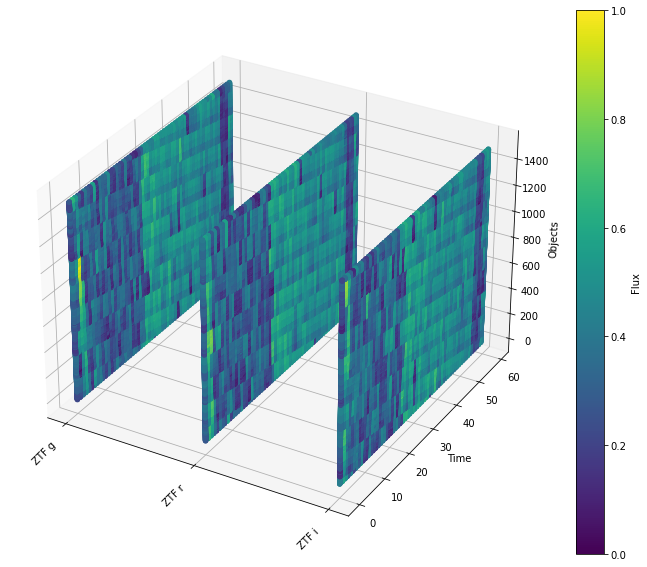

In [9]:
depth, rows, cols = objects.shape
x, y, z = np.meshgrid( np.arange(rows), np.arange(cols),np.arange(depth))
x,y,z = x.flatten(),y.flatten(),z.flatten()
values = objects.flatten()

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=np.log10(values), cmap='viridis')
custom_x_labels = ['ZTF g','ZTF r','ZTF i']
ax.set_xticks(np.arange(len(custom_x_labels)))
ax.set_xticklabels(custom_x_labels, rotation=45, ha='right')  # Adjust rotation and alignment as needed
ax.set_ylabel('Time')
ax.set_zlabel('Objects')

sm = plt.cm.ScalarMappable()
sm.set_array([])
fig.colorbar(sm, label='Flux')

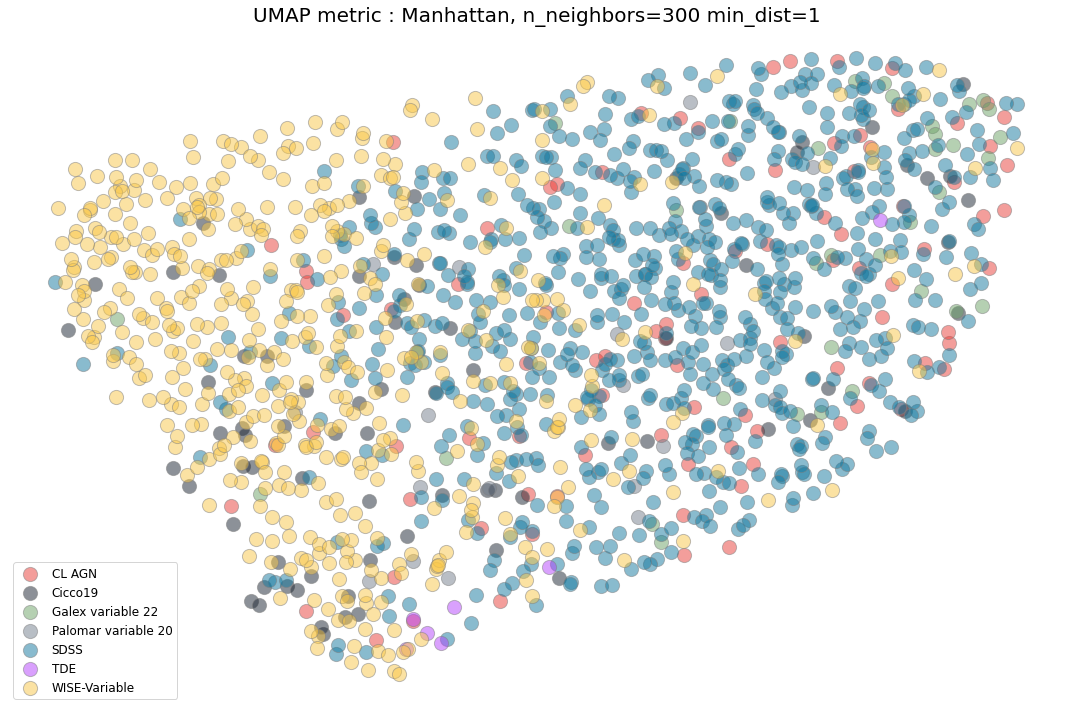

In [10]:
plt.style.use('seaborn-colorblind')
plt.figure(figsize=(15,10))
markersize=200
colors = ['#e93e39','#1b2532','#6ca267','#747e8c','#14789f','#b444fc','#f9c748']
mapperg = umap.UMAP(n_neighbors=300,min_dist=1,metric='manhattan',random_state=20).fit(data)
for l,lab in enumerate(np.unique(fzr)):
    ax0 = plt.subplot(1,1,1)
    ax0.set_title('UMAP metric : Manhattan, n_neighbors='+str(300)+' min_dist=1',size=20)
    u=(fzr[:]==lab)
    cf = ax0.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=markersize,c=colors[l],alpha=0.5,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.axis('off')
plt.tight_layout()
#plt.savefig('umap-Panstarrs.png')